In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


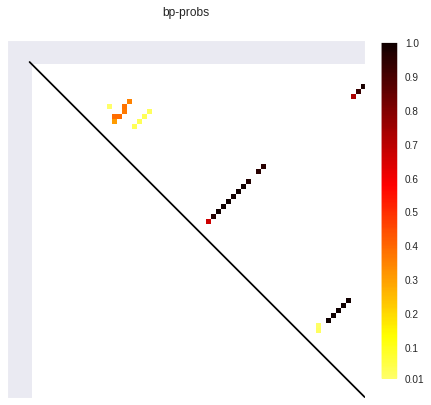

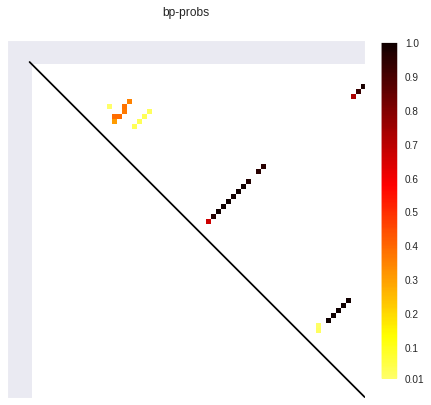

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *

plt.rcParams["axes.grid"] = True
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally


trna="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"

plot_heat_maps(None, getBPPM(trna), filename='/tmp/trna', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)

In [3]:
def walk_basepairs_get_stems(mat, p_thresh=0.5, inner_loop=False):
    bpXs, bpYs = np.where(mat > p_thresh) # Note: hopefully the returned  indices of where are sorted by x values
    bpXs +=1
    bpYs += 1 
    if len(bpXs) == 0:
        #print ("WARNING: No basepair with prob larger than {}".format(p_thresh))
        return {}
        
    # startX: 3'end startY:5'end of the stem
    stem_startX, stem_startY = bpXs[0], bpYs[0]
    stem_endX, stem_endY = bpXs[0], bpYs[0]
    stems_dict = {} 
    stems_list = []
    for x, y in zip(bpXs, bpYs):
        #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)

        #print x,y,
        if ( abs(x-stem_endX) <= 5 and abs(y-stem_endY) <= 5 and
               ((~inner_loop and ( (abs(x-stem_endX) <= 1) or (abs(y-stem_endY) <= 1)))
                or 
                (inner_loop  and ( (abs(x-stem_endX) <= 3) or (abs(y-stem_endY) <= 3)))
               )
               ):
        
            
#             if (abs(x-stem_endX) >= 5) or (abs(y-stem_endY) >= 5):
#                 print "WARNING: bulge of size larger than 5 added at x={}, y={}! ".format(x,y)
                
            stem_endX = x
            stem_endY = y
        else:
            #print " new",
            #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # Validating order of stem indices
            
            assert stem_startX <= stem_endX
            assert stem_endX < stem_endY
            assert stem_endY <= stem_startY
            
            # stem coords as key string
            k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # stem length as dict value
            stems_dict[k] = max( (stem_endX-stem_startX) , (stem_startY-stem_endY)), stem_endY-stem_endX
            
            stem_startX, stem_startY = x, y
            stem_endX, stem_endY = x, y
    
    k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
    #print k, stem_endX-stem_startX , (stem_startY-stem_endY)
    assert k not in stems_dict # It should be the case always..?
    stems_dict[k] = max( (stem_endX-stem_startX+1) , (stem_startY-stem_endY+1)), stem_endY-stem_endX 
    
    return stems_dict

import pandas as pd
from Bio import SeqIO
def fasta_to_df(fasta_file, use_dpps_folder=False, add_shuffle=True,add_bpmat=True):
    seq_recs = list(SeqIO.parse(fasta_file, format='fasta'))
    df_fasta = pd.DataFrame(index=[r.id for r in seq_recs])

    df_fasta['sequence'] = [str(s.seq).replace('T','U').replace('t','u') for s in seq_recs] 
    if add_shuffle:
        df_fasta['sequence-shuffled'] = [dinuclShuffle(s.upper().replace('T','U')) for s in df_fasta['sequence']]
    if add_bpmat:
        df_fasta['bp-matrix'] = [getBPPM(s) for s in df_fasta['sequence']]
        if add_shuffle:
            df_fasta['bp-matrix-shuffled'] = [getBPPM(s) for s in df_fasta['sequence-shuffled']]
    return df_fasta
# walk_basepairs_get_stems(bpmat,inner_loop=True)
# bpXs, bpYs = np.where(bpmat>0.5)
# zip(bpXs, bpYs, bpXs+1, bpYs+1)


In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import re
import seaborn as sns

def filter_stemsd_list(sdl, max_inner_distance=10, min_stem_length=4):
    sdl_filt = list()
    for sd in sdl:
        #print sd
        sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
        #print sd_filt
        #print
        sdl_filt.append(sd_filt)
    return sdl_filt

from matplotlib_venn import venn2#, venn3_circles
def plot_venn(stems, rangeA = (45,55), rangeB = (73,83), ax=None):
    setinA, setinB = set(), set()

    for ids, sdic in enumerate(stems):
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in sdic]
        inA = 0 < len([c for c in centers if rangeA[0]<=c<=rangeA[1]])
        inB = 0 < len([c for c in centers if rangeB[0]<=c<=rangeB[1]])
        if inA:
            setinA.add(ids)
        if inB:
            setinB.add(ids)
        
    venn2([setinA, setinB], set_labels =['SL-center {}-{}'.format(*rangeA),'SL-center {}-{}'.format(*rangeB)],ax=ax)
    
def plot_stems_loc(stemdl_nonfilt, title='',filt=False, max_inner_distance=10, min_stem_length=7, venn=True,rangeA = (45,55), rangeB = (73,83),):
    if filt is True:
        stemdl = filter_stemsd_list(stemdl_nonfilt)
    else:
        stemdl = stemdl_nonfilt
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    #starts = [ int(re.split("\D+", k)[1]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(starts, ax=ax,label='starts')
    #ends = [ int(re.split("\D+", k)[2]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(ends,ax=ax,label='ends')
    
    centers = [ int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for sd in stemdl for k in sd  if len(sd)>0 ]
    #print centers
    sns.distplot(centers,ax=axes[1],label='stemloop-centers n:{}'.format(len(centers)))
    axes[1].legend()
    axes[1].text(x = 120, y=0.01, s='#seqs: {}\n#seqs-with-MEA-structure: {}\n#seqs-with-stemloop: {}\n\n     '.format(len(stemdl_nonfilt), 
                                                                                  len([sd for sd in stemdl_nonfilt if len(sd)>0]),
                                                                                  len([sd for sd in stemdl if len(sd)>0]),
                                                                                   
                                                                                                                          ),
            horizontalalignment='left',
                )
    if venn is True:
        plot_venn(stemdl,ax=axes[0],rangeA=rangeA, rangeB=rangeB)
    fig.suptitle(title + '\nStemLoop analysis of MEA structures\n' +   'SL-min-paired:{} SL-max-unpaired:{}'.format(min_stem_length,max_inner_distance)
                , y=1.0)
    
import numpy as np

def annotate_stems(df, rangeA = (45,55), rangeB = (73,83), ax=None):
    stems_nonfilt = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
    stems = filter_stemsd_list(stems_nonfilt)

    filter_stemsd_list
    stemA, stemB = [None]*len(df),[None]*len(df)
    inAarr, inBarr = [False]*len(df),[False]*len(df)
    for ids, sdic in enumerate(stems):
        keys = [k for k in sdic]
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in keys]
        diffs = [int(re.split("\D+", k)[2]) -int(re.split("\D+", k)[1]) for k in keys]
        isinA = [rangeA[0]<=c<=rangeA[1] for c in centers ]
        isinB = [rangeB[0]<=c<=rangeB[1] for c in centers ]
        if  True in isinA:
            if isinA.count(True)>1:
                print "Multiple centersA", [k for i,k in enumerate(keys) if isinA[i]]
            inAarr[ids] = True
            dicdiffs = {keys[i]:d for i,d in enumerate(diffs) if isinA[i]}
            mindif = min(dicdiffs.values())
            stemA[ids] = dicdiffs.keys()[dicdiffs.values().index(mindif)]

 
                              
        if True in isinB:
            if isinB.count(True)>1:
                print "Multiple centersB", [k for i,k in enumerate(keys) if isinB[i]]
            inBarr[ids] = True
            dicdiffs = {keys[i]:d for i,d in enumerate(diffs) if isinB[i]}
            mindif = min(dicdiffs.values())
            
            stemB[ids] = dicdiffs.keys()[dicdiffs.values().index(mindif)]
#             print stemB[ids], keys, isinB, mindif
        
    df['stem-inA'] = stemA
    df['stem-inB'] = stemB
    
    return df


    

In [ ]:
fa_peakcentered = '../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta' #('../../GalaxyGraphClust/Staufen/Galaxy7-[stau-extended100-fixed-centered.fa].fasta')
mydf_peakcentered = fasta_to_df(fa_peakcentered)
annotate_stems(mydf_peakcentered)

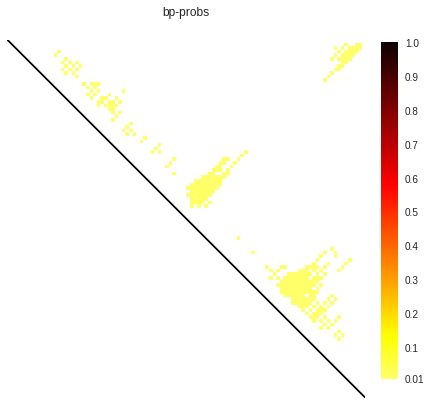

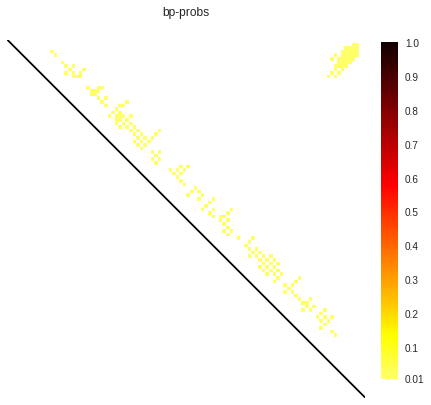

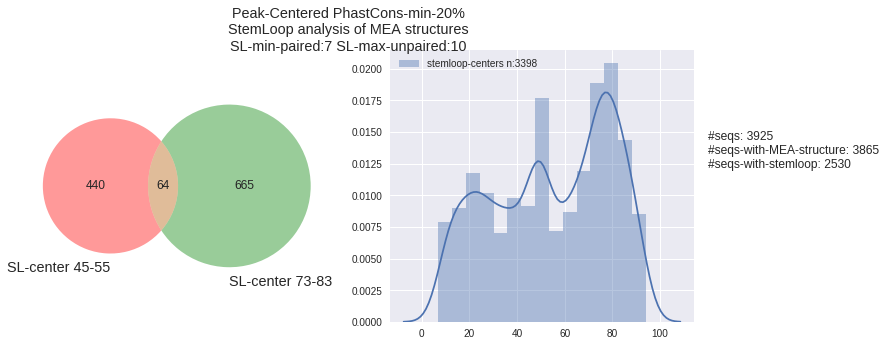

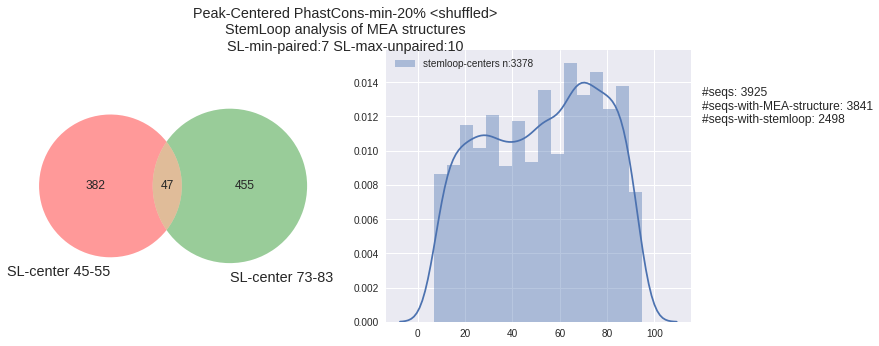

In [7]:

def analyze_df(df, filename,title='',average=True, walk_stems=True, venn=True, filt=False,rangeA = (45,55), rangeB = (73,83)):
    if average:
        average_bpmat = np.average(df['bp-matrix'])
        average_bpmat_shuff = np.average(df['bp-matrix-shuffled'])
        fig_file = filename.replace('fasta','fa').replace('.fa','.shuffled.dp')
        fig_file_shuff = filename.replace('fasta','fa').replace('.fa','.dp')
        plot_heat_maps(None, average_bpmat, filename=fig_file, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
        plot_heat_maps(None, average_bpmat_shuff, filename=fig_file_shuff, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
        
    if walk_stems:
        stems = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
        plot_stems_loc(stems,venn=venn, filt=filt,title=title)
        plt.show()
        stems_shuf = [walk_basepairs_get_stems(s) for s in df['bp-matrix-shuffled']]
        plot_stems_loc(stems_shuf,venn=venn,rangeA = (45,55), rangeB = (73,83),filt=filt,title=title+' <shuffled>')
        plt.show()
        
analyze_df(mydf_peakcentered,fa_peakcentered,title='Peak-Centered PhastCons-min-20%',average=True,walk_stems=True,filt=True)

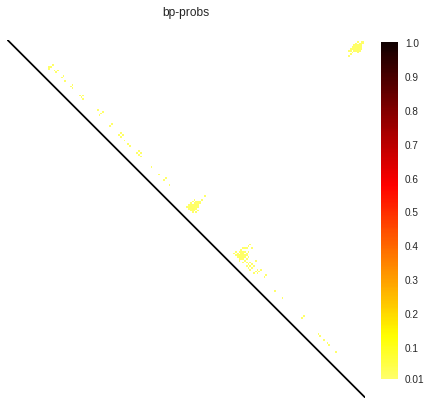

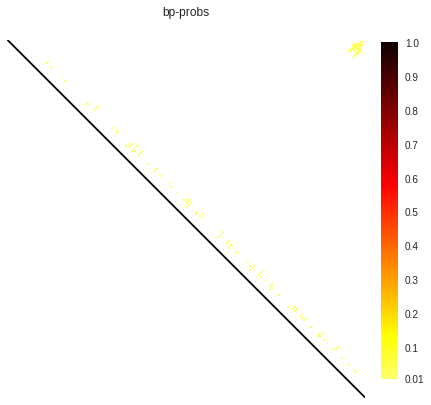

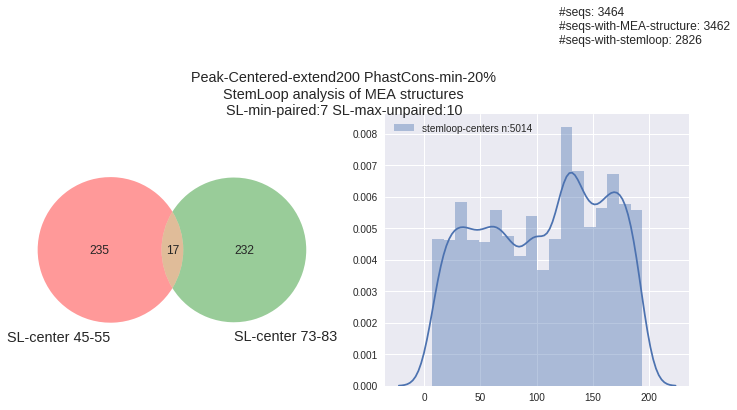

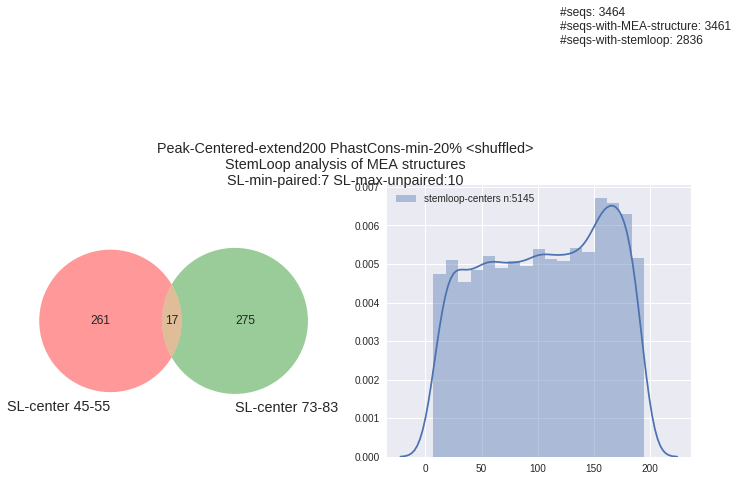

In [8]:
fa_peakcentered200 = '../../GalaxyGraphClust/Staufen/Galaxy21-[stau-phastcons20-nomerge-extended200-fixed-centered.fa].fasta'
mydf_peakcentered200 = fasta_to_df(fa_peakcentered200)
annotate_stems(mydf_peakcentered200,rangeA=(95,105),rangeB=(123,133))


analyze_df(mydf_peakcentered200,fa_peakcentered200,title='Peak-Centered-extend200 PhastCons-min-20%',average=True,walk_stems=True,filt=True,rangeA=(95,105),rangeB=(123,133))

In [21]:
def extract_stem_seqs(df,target='stem-inA',pad=0,downup_stream=0,full_seq=False):
    
    df_A = df[df[target].notnull()]
    if full_seq is True:
        with open('./phastcos20-peakcentered-stemB100-fullseq200.fa','w') as outfa:
            outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in df_peakcentered200_stemA100['sequence'].to_dict().items() if len(s)>=8])
        return df_A['sequence'].to_dict()
    seqsA_dic = dict()
    seqsAUP_dic =dict()
    for index, row in df_A.iterrows():
        #print row['sequence'], row['stem-inA']
        if downup_stream != 0:
            assert pad == 0
            if downup_stream < 0:
                cut_range = (int(row[target].split('-')[0])+downup_stream, int(row[target].split('-')[0]))
            else:
                cut_range = (int(row[target].split('-')[2])+1 , int(row[target].split('-')[2])+1+downup_stream)
        else:
            cut_range = (int(row[target].split('-')[0])-pad, int(row[target].split('-')[2])+1+pad)
                
        seqsA_dic[index] = row['sequence'][cut_range[0]:cut_range[1]]
#             int(row['stem-inA'].split('-')[0])-pad+shift: int(row['stem-inA'].split('-')[0])-pad
#             int(row['stem-inA'].split('-')[2])+1-pad: int(row['stem-inA'].split('-')[2])+1-pad+shift
                                          # int(row['stem-inA'].split('-')[2])+1+pad+shift
#                                           ]#.str.slice(df_A.head()['stem-inA'].str.split('-').str[0].astype(int), df_A.head()['stem-inA'].str.split('-').str[2].astype(int))
        if len(seqsA_dic[index]) < 8:
            print "Warning sequence length less than 8 for ", index
        seqsAUP_dic[index] = row['sequence'][int(row[target].split('-')[1].split(',')[0]): 
                                           int(row[target].split('-')[1].split(',')[1])+1]
    with open('./phastcos20-peakcentered-stemsB-downstream20.fa','w') as outfa:
    outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in seqsA_peakc.items() if len(s)>=8])

    with open('./phastcos20-peakcentered-stemsB-Unpaired.fa','w') as outfa:
        outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in unpaired_peakc.items() if len(s)>=8])
    #return seqsA_dic, seqsAUP_dic

extract_stem_seqs(mydf_peakcentered,target='stem-inA',pad=0,downup_stream=0)
# fullseqsB = extract_stem_seqs(mydf_peakcentered,target='stem-inB',full_seq=True)

In [167]:
keys100to200 = ['{}_{}_{}_{}_{}'.format(k.split('_')[0],k.split('_')[1],int(k.split('_')[2])-50,int(k.split('_')[3])+50,k.split('_')[4]) for k in seqsAB_peakc ]
df_peakcentered200_stemA100 = mydf_peakcentered200[mydf_peakcentered200.index.isin(keys100to200)]

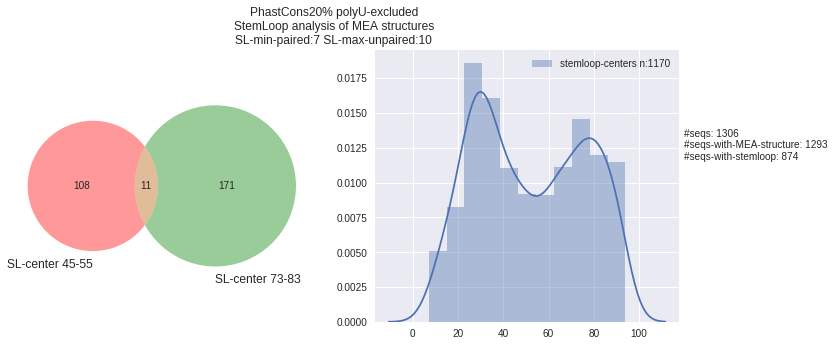

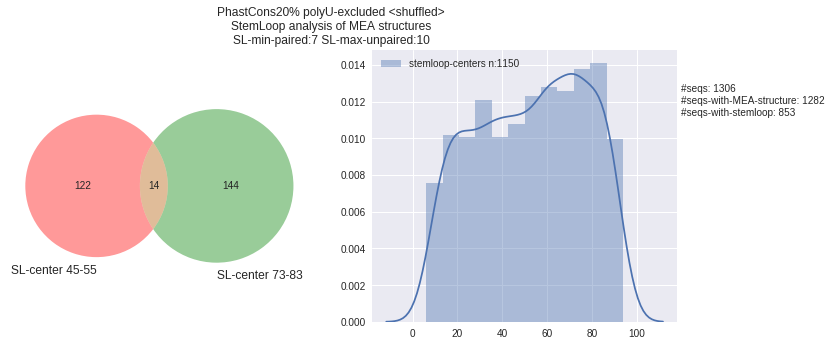

In [276]:
mydf_peakcentered = fasta_to_df('../../GalaxyGraphClust/Staufen/Galaxy7-[stau-extended100-fixed-centered.fa].fasta')
analyze_df(mydf_peakcentered,'stau-extended100-fixed-centered.fa',title='peak-centered',filt=True)

# analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
#            , fasta_phast20, average=False,walk_stems=True)
analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
           , fasta_phast20, title='PhastCons20% polyU-excluded',average=False,walk_stems=True,filt=True,)
